# Deep Reinforcement Learning for Optimal Execution of Portfolio Transactions     

In [1]:
!pip install statsmodels

In [2]:
!pip install --upgrade statsmodels

In [3]:
from itertools import zip_longest


In [5]:
!pip install python-utils

In [6]:
#import python_utils
#from python_utils.import_ import import_global
# Get the default financial and AC Model parameters
financial_params, ac_params = get_env_param()

In [7]:
financial_params

Annual Volatility:,12%,Bid-Ask Spread:,0.125
Daily Volatility:,0.8%,Daily Trading Volume:,"5,000,000"


In [8]:
ac_params

Total Number of Shares for Agent1 to Sell:,"500,000",Fixed Cost of Selling per Share:,$0.062
Total Number of Shares for Agent2 to Sell:,"500,000",Trader's Risk Aversion for Agent 1:,1e-06
Starting Price per Share:,$50.00,Trader's Risk Aversion for Agent 2:,0.0001
Price Impact for Each 1% of Daily Volume Traded:,$2.5e-06,Permanent Impact Constant:,2.5e-07
Number of Days to Sell All the Shares:,60,Single Step Variance:,0.144
Number of Trades:,60,Time Interval between trades:,1.0


In [9]:
!pip install torch

In [33]:
import numpy as np

import syntheticChrissAlmgren as sca
from ddpg_agent import Agent

from collections import deque

# Create simulation environment
env = sca.MarketEnvironment()


# Tune the hyperparameters
learning_rate_actor = 1e-4  # Learning rate for the actor
learning_rate_critic = 1e-3  # Learning rate for the critic



# Initialize Feed-forward DNNs for Actor and Critic models. 
agent1 = Agent(state_size=env.observation_space_dimension(), action_size=env.action_space_dimension(),random_seed = 1225, learning_rate_actor=learning_rate_actor, learning_rate_critic=learning_rate_critic)
agent2 = Agent(state_size=env.observation_space_dimension(), action_size=env.action_space_dimension(),random_seed = 108, learning_rate_actor=learning_rate_actor, learning_rate_critic=learning_rate_critic)
# Example of creating an agent with specific learning rates
#agent = Agent(state_size=33, action_size=4, random_seed=2, learning_rate_actor=1e-4, learning_rate_critic=1e-3)
shortfall_history_agent1 = []
shortfall_history_agent2 = []

noise_scale = 2.0  # This value would be tuned to balance exploration and exploitation
noise_reduction_factor = 0.6  # To reduce noise over episodes



# Initialize agents with new hyperparameters and noise scaling




# Set the liquidation time
lqt = 60

# Set the number of trades
n_trades = 60

# Set trader's risk aversion
tr1 = 1e-6
tr2 = 1e-6

# Set the number of episodes to run the simulation
episodes = 1300
shortfall_list = []
shortfall_hist1 = np.array([])
shortfall_hist2 = np.array([])
shortfall_deque1 = deque(maxlen=100)
shortfall_deque2 = deque(maxlen=100)
for episode in range(episodes): 
    # Reset the enviroment
    cur_state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1,lamb2 = tr2)

    # set the environment to make transactions
    env.start_transactions()

    for i in range(n_trades + 1):
      
        # Predict the best action for the current state. 
        cur_state1 = np.delete(cur_state,8)
        cur_state2 = np.delete(cur_state,7)
        #print(cur_state[5:])
        #action1 = agent1.act(cur_state1, add_noise = True)
        #action2 = agent2.act(cur_state2, add_noise = True)


        action1 = agent1.act(cur_state1, add_noise=True) * noise_scale
        action2 = agent2.act(cur_state2, add_noise=True) * noise_scale

        noise_scale *= noise_reduction_factor



        #print(action1,action2)
        # Action is performed and new state, reward, info are received. 
        new_state, reward1, reward2, done1, done2, info = env.step(action1,action2)
        
        # current state, action, reward, new state are stored in the experience replay
        new_state1 = np.delete(new_state,8)
        new_state2 = np.delete(new_state,7)
        agent1.step(cur_state1, action1, reward1, new_state1, done1)
        agent2.step(cur_state2, action2, reward2, new_state2, done2)
        # roll over new state
        cur_state = new_state

        if info.done1 and info.done2:
            shortfall_hist1 = np.append(shortfall_hist1, info.implementation_shortfall1)
            shortfall_deque1.append(info.implementation_shortfall1)
            
            shortfall_hist2 = np.append(shortfall_hist2, info.implementation_shortfall2)
            shortfall_deque2.append(info.implementation_shortfall2)
            break
    shortfall_history_agent1.append(abs(np.mean(shortfall_deque1)))
    shortfall_history_agent2.append(abs(np.mean(shortfall_deque2)))
        
    if (episode + 1) % 100 == 0: # print average shortfall over last 100 episodes
        print('\rEpisode [{}/{}]\tAverage Shortfall for Agent1: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque1)))        
        print('\rEpisode [{}/{}]\tAverage Shortfall for Agent2: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque2)))
        shortfall_list.append([np.mean(shortfall_deque1),np.mean(shortfall_deque2)])
print('\nAverage Implementation Shortfall for Agent1: ${:,.2f} \n'.format(np.mean(shortfall_hist1)))
print('\nAverage Implementation Shortfall for Agent2: ${:,.2f} \n'.format(np.mean(shortfall_hist2)))

Episode [100/1300]	Average Shortfall for Agent1: $1,378,970.56
Episode [100/1300]	Average Shortfall for Agent2: $1,373,533.11
Episode [200/1300]	Average Shortfall for Agent1: $1,377,392.67
Episode [200/1300]	Average Shortfall for Agent2: $1,377,392.67
Episode [300/1300]	Average Shortfall for Agent1: $1,534,902.16
Episode [300/1300]	Average Shortfall for Agent2: $1,534,902.16
Episode [400/1300]	Average Shortfall for Agent1: $1,583,899.65
Episode [400/1300]	Average Shortfall for Agent2: $1,583,899.65
Episode [500/1300]	Average Shortfall for Agent1: $1,115,616.54
Episode [500/1300]	Average Shortfall for Agent2: $1,115,616.54
Episode [600/1300]	Average Shortfall for Agent1: $1,335,245.90
Episode [600/1300]	Average Shortfall for Agent2: $1,335,245.90
Episode [700/1300]	Average Shortfall for Agent1: $1,034,020.91
Episode [700/1300]	Average Shortfall for Agent2: $1,034,020.91
Episode [800/1300]	Average Shortfall for Agent1: $1,438,291.33
Episode [800/1300]	Average Shortfall for Agent2: $1,438

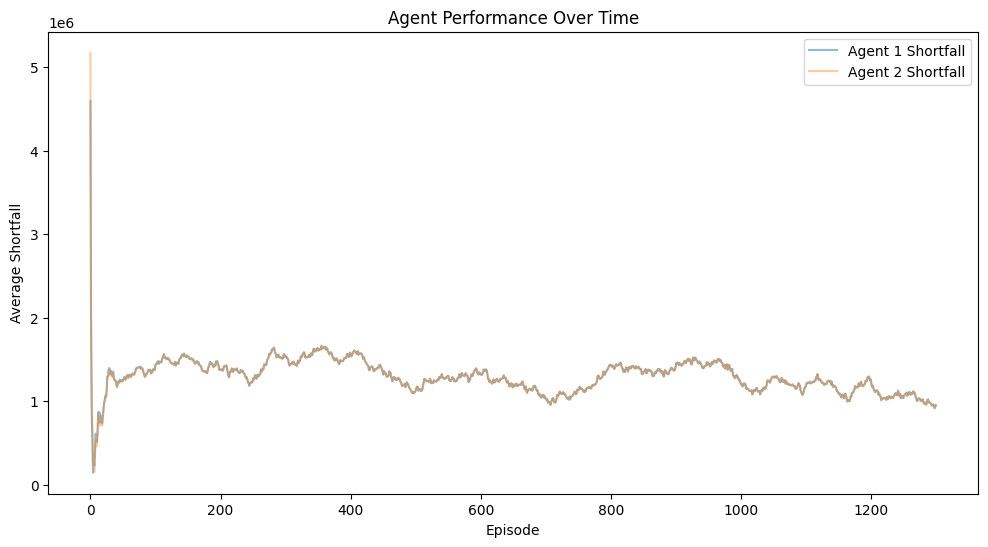

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(shortfall_history_agent1, label='Agent 1 Shortfall', alpha = 0.5)
plt.plot(shortfall_history_agent2, label='Agent 2 Shortfall', alpha = 0.4)
plt.xlabel('Episode')
plt.ylabel('Average Shortfall')
plt.title('Agent Performance Over Time')
plt.legend()
plt.show()

In [42]:
shortfall = np.array(shortfall_list)

In [43]:
np.save('1e-6_1e-2_cooporation_shorfall_list.npy',shortfall)

In [44]:
print(tr1,tr2)
cur_state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1,lamb2 = tr2)

    # set the environment to make transactions
env.start_transactions()

trajectory = np.zeros([n_trades+1,2])
for i in range(n_trades + 1):
    trajectory[i] = cur_state[7:]
    
    print(cur_state[7:])
        # Predict the best action for the current state. 
    cur_state1 = np.delete(cur_state,8)
    cur_state2 = np.delete(cur_state,7)
        #print(cur_state[5:])
    action1 = agent1.act(cur_state1, add_noise = True)
    action2 = agent2.act(cur_state2, add_noise = True)
        #print(action1,action2)
        # Action is performed and new state, reward, info are received. 
    new_state, reward1, reward2, done1, done2, info = env.step(action1,action2)
        
        # current state, action, reward, new state are stored in the experience replay
    new_state1 = np.delete(new_state,8)
    new_state2 = np.delete(new_state,7)
    agent1.step(cur_state1, action1, reward1, new_state1, done1)
    agent2.step(cur_state2, action2, reward2, new_state2, done2)
        # roll over new state
    cur_state = new_state

    if info.done1 and info.done2:
        shortfall_hist1 = np.append(shortfall_hist1, info.implementation_shortfall1)
        shortfall_deque1.append(info.implementation_shortfall1)
            
        shortfall_hist2 = np.append(shortfall_hist2, info.implementation_shortfall2)
        shortfall_deque2.append(info.implementation_shortfall2)
        break
        
if (episode + 1) % 100 == 0: # print average shortfall over last 100 episodes
    print('\rEpisode [{}/{}]\tAverage Shortfall for Agent1: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque1)))        
    print('\rEpisode [{}/{}]\tAverage Shortfall for Agent2: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque2)))


1e-06 0.01
[1. 1.]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
Episode [1300/1300]	Average Shortfall for Agent1: $nan
Episode [1300/1300]	Average Shortfall for Agent2: $nan


In [45]:
np.save('1e-6_1e-2_competition_trajectory_1500.npy',trajectory)

In [48]:
%matplotlib inline

import matplotlib.pyplot as plt

#import utils

# We set the default figure size
plt.rcParams['figure.figsize'] = [17.0, 7.0]


# Set the number of days to sell all shares (i.e. the liquidation time)
l_time = 60

# Set the number of trades
n_trades = 60

# Set the trader's risk aversion
t_risk = 1e-6

# Plot the trading list and trading trajectory. If show_trl = True, the data frame containing the values of the
# trading list and trading trajectory is printed
#plot_trade_list(lq_time = l_time, nm_trades = n_trades, tr_risk = t_risk, show_trl = True)
plot_trade_list(lq_time = 60, nm_trades = 60, tr_risk = 1e-6, show_trl = True)

TypeError: reset() got an unexpected keyword argument 'lamb'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import syntheticChrissAlmgren as sca

from statsmodels.iolib.table import SimpleTable
#from statsmodels.compat.python import zip_longest
from statsmodels.iolib.tableformatting import fmt_2cols


def generate_table(left_col, right_col, table_title):
    
    # Do not use column headers
    col_headers = None
    
    # Generate the right table
    if right_col:
        # Add padding
        if len(right_col) < len(left_col):
            right_col += [(' ', ' ')] * (len(left_col) - len(right_col))
        elif len(right_col) > len(left_col):
            left_col += [(' ', ' ')] * (len(right_col) - len(left_col))
        right_col = [('%-21s' % ('  '+k), v) for k,v in right_col]
        
        # Generate the right table
        gen_stubs_right, gen_data_right = zip_longest(*right_col)
        gen_table_right = SimpleTable(gen_data_right,
                                          col_headers,
                                          gen_stubs_right,
                                          title = table_title,
                                          txt_fmt = fmt_2cols)
    else:
        # If there is no right table set the right table to empty
        gen_table_right = []

    # Generate the left table  
    gen_stubs_left, gen_data_left = zip_longest(*left_col) 
    gen_table_left = SimpleTable(gen_data_left,
                                 col_headers,
                                 gen_stubs_left,
                                 title = table_title,
                                 txt_fmt = fmt_2cols)

    
    # Merge the left and right tables to make a single table
    gen_table_left.extend_right(gen_table_right)
    general_table = gen_table_left

    return general_table


def get_env_param():
    
    # Create a simulation environment
    env = sca.MarketEnvironment()

    # Set the title for the financial parameters table
    fp_title = 'Financial Parameters'

    # Get the default financial parameters from the simulation environment
    fp_left_col = [('Annual Volatility:', ['{:.0f}%'.format(env.anv * 100)]),
                   ('Daily Volatility:', ['{:.1f}%'.format(env.dpv * 100)])]
    
    fp_right_col = [('Bid-Ask Spread:', ['{:.3f}'.format(env.basp)]),
                    ('Daily Trading Volume:', ['{:,.0f}'.format(env.dtv)])]

    # Set the title for the Almgren and Chriss Model parameters table
    acp_title = 'Almgren and Chriss Model Parameters'

    # Get the default Almgren and Chriss Model Parameters from the simulation environment
    acp_left_col = [('Total Number of Shares for Agent1 to Sell:', ['{:,}'.format(env.total_shares1)]),
                    ('Total Number of Shares for Agent2 to Sell:', ['{:,}'.format(env.total_shares2)]),
                    ('Starting Price per Share:', ['${:.2f}'.format(env.startingPrice)]),
                    ('Price Impact for Each 1% of Daily Volume Traded:', ['${}'.format(env.eta)]),                    
                    ('Number of Days to Sell All the Shares:', ['{}'.format(env.liquidation_time)]),
                    ('Number of Trades:', ['{}'.format(env.num_n)])]

    acp_right_col = [('Fixed Cost of Selling per Share:', ['${:.3f}'.format(env.epsilon)]),
                     ('Trader\'s Risk Aversion for Agent 1:', ['{}'.format(env.llambda1)]),
                     ('Trader\'s Risk Aversion for Agent 2:', ['{}'.format(env.llambda2)]),
                     ('Permanent Impact Constant:', ['{}'.format(env.gamma)]),
                     ('Single Step Variance:', ['{:.3f}'.format(env.singleStepVariance)]),
                     ('Time Interval between trades:', ['{}'.format(env.tau)])]

    # Generate tables with the default financial and AC Model parameters
    fp_table = generate_table(fp_left_col, fp_right_col, fp_title)
    acp_table = generate_table(acp_left_col, acp_right_col, acp_title)

    return fp_table, acp_table


def plot_price_model(seed = 0, num_days = 1000):
    
    # Create a simulation environment
    env = sca.MarketEnvironment()

    # Reset the enviroment with the given seed
    env.reset(seed)

    # Create an array to hold the daily stock price for the given number of days
    price_hist = np.zeros(num_days)

    # Get the simulated stock price movement from the environment
    for i in range(num_days):
        _, _, _, info = env.step(i)    
        price_hist[i] = info.price
    
    # Print Average and Standard Deviation in Stock Price
    print('Average Stock Price: ${:,.2f}'.format(price_hist.mean()))
    print('Standard Deviation in Stock Price: ${:,.2f}'.format(price_hist.std()))
#     print('Standard Deviation of Random Noise: {:,.5f}'.format(np.sqrt(env.singleStepVariance * env.tau)))
    
    # Plot the price history for the given number of days
    price_df = pd.DataFrame(data = price_hist,  columns = ['Stock'], dtype = 'float64')
    ax = price_df.plot(colormap = 'cool', grid = False)
    ax.set_facecolor(color = 'k')
    ax = plt.gca()
    yNumFmt = mticker.StrMethodFormatter('${x:,.2f}')
    ax.yaxis.set_major_formatter(yNumFmt)
    plt.ylabel('Stock Price')
    plt.xlabel('days')
    plt.show()
    

    
def get_optimal_vals(lq_time = 60, nm_trades = 60, tr_risk = 1e-6, title = ''):
    
    # Create a simulation environment
    env = sca.MarketEnvironment()

    # Reset the enviroment with the given parameters
    env.reset(liquid_time = lq_time, num_trades = nm_trades, lamb = tr_risk)

    # Set the title for the AC Optimal Strategy table
    if title == '':
        title = 'AC Optimal Strategy'
    else:
        title = 'AC Optimal Strategy for ' + title

    # Get the AC optimal values from the environment
    E = env.get_AC_expected_shortfall(env.total_shares)
    V = env.get_AC_variance(env.total_shares)
    U = env.compute_AC_utility(env.total_shares)

    left_col = [('Number of Days to Sell All the Shares:', ['{}'.format(env.liquidation_time)]),
                ('Half-Life of The Trade:', ['{:,.1f}'.format(1 / env.kappa)]),
                ('Utility:', ['${:,.2f}'.format(U)])]

    right_col = [('Initial Portfolio Value:', ['${:,.2f}'.format(env.total_shares * env.startingPrice)]),
                 ('Expected Shortfall:', ['${:,.2f}'.format(E)]),
                 ('Standard Deviation of Shortfall:', ['${:,.2f}'.format(np.sqrt(V))])]

    # Generate the table with the AC optimal values
    val_table = generate_table(left_col, right_col, title)

    return val_table


def get_min_param():
    
    # Get the minimum impact AC parameters
    min_impact = get_optimal_vals(lq_time = 250, nm_trades = 250, tr_risk = 1e-17, title = 'Minimum Impact')
    
    # Get the minimum variance AC parameters
    min_var = get_optimal_vals(lq_time = 1, nm_trades = 1, tr_risk = 0.0058, title = 'Minimum Variance')
    
    return min_impact, min_var
  
            
def get_crfs(trisk):
    
    # Create the annotation label
    tr_st = '{:.0e}'.format(trisk)   
    lnum = tr_st.split('e')[0]   
    lexp = tr_st.split('e')[1]
    if np.abs(np.int(lexp)) < 10:
        lexp = lexp.replace('0', '', 1)    
    an_st = '$\lambda = ' + lnum + ' \\times 10^{' + lexp + '}$'
    
    # Set the correction factors for the annotation label
    if trisk >= 1e-7 and trisk <= 4e-7:
        xcrf = 0.94
        ycrf = 2.5
        scrf = 0.1
    elif trisk > 4e-7 and trisk <= 9e-7:
        xcrf = 0.9
        ycrf = 2.5
        scrf = 0.06
    elif trisk > 9e-7 and trisk <= 1e-6:
        xcrf = 0.85
        ycrf = 2.5
        scrf = 0.06
    elif trisk > 1e-6 and trisk < 2e-6:
        xcrf = 1.2
        ycrf = 2.5
        scrf = 0.06
    elif trisk >= 2e-6 and trisk < 3e-6:
        xcrf = 0.8
        ycrf = 2.5
        scrf = 0.06
    elif trisk >= 3e-6 and trisk < 4e-6:
        xcrf = 0.7
        ycrf = 2.5
        scrf = 0.08
    elif trisk >= 4e-6 and trisk < 7e-6:
        xcrf = 1.4
        ycrf = 2.0
        scrf = 0.08
    elif trisk >= 7e-6 and trisk <= 1e-5:
        xcrf = 4.5
        ycrf = 1.5
        scrf = 0.08
    elif trisk > 1e-5 and trisk <= 2e-5:
        xcrf = 7.0
        ycrf = 1.1
        scrf = 0.08
    elif trisk > 2e-5 and trisk <= 5e-5:
        xcrf = 12.
        ycrf = 1.1
        scrf = 0.08
    elif trisk > 5e-5 and trisk <= 1e-4:
        xcrf = 30
        ycrf = 0.99
        scrf = 0.08
    else:
        xcrf = 1
        ycrf = 1
        scrf = 0.08
    
    return an_st, xcrf, ycrf, scrf
    

def plot_efficient_frontier(tr_risk = 1e-6):
    
    # Create a simulation environment
    env = sca.MarketEnvironment()
    
    # Reset the enviroment with the given trader's risk aversion
    env.reset(lamb = tr_risk)

    # Get the expected shortfall and corresponding variance for the given trader's risk aversion
    tr_E = env.get_AC_expected_shortfall(env.total_shares)
    tr_V = env.get_AC_variance(env.total_shares)
    
    # Create empty arrays to hold our values of E, V, and U
    E = np.array([])
    V = np.array([])
    U = np.array([])
    
    # Set the number of plot points for our frontier
    num_points = 7000
    
    # Set the values of the trader's risk aversion to plot
    lambdas = np.linspace(1e-7, 1e-4, num_points)
    
    # Calclate E, V, U for each value of llambda
    for llambda in lambdas:
        env.reset(lamb = llambda)
        E = np.append(E, env.get_AC_expected_shortfall(env.total_shares))
        V = np.append(V, env.get_AC_variance(env.total_shares))
        U = np.append(U, env.compute_AC_utility(env.total_shares))
        
    # Plot E vs V and use U for the colorbar    
    cm = plt.cm.get_cmap('gist_rainbow')    
    sc = plt.scatter(V, E, s = 20, c = U, cmap = cm)
    plt.colorbar(sc, label = 'AC Utility', format = mticker.StrMethodFormatter('${x:,.0f}'))
    ax = plt.gca()
    ax.set_facecolor('k')
    ymin = E.min() * 0.7
    ymax = E.max() * 1.1
    plt.ylim(ymin, ymax)
    yNumFmt = mticker.StrMethodFormatter('${x:,.0f}')
    xNumFmt = mticker.StrMethodFormatter('{x:,.0f}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.xaxis.set_major_formatter(xNumFmt)
    plt.xlabel('Variance of Shortfall')
    plt.ylabel('Expected Shortfall')
    
    # Get the annotation label and the correction factors
    an_st, xcrf, ycrf, scrf = get_crfs(tr_risk)
    
    # Plot the annotation in the above plot
    plt.annotate(an_st, xy = (tr_V, tr_E), xytext = (tr_V * xcrf, tr_E  * ycrf), color = 'w', size = 'large', 
                 arrowprops = dict(facecolor = 'cyan', shrink = scrf, width = 3, headwidth = 10))
    plt.show()
    
    
def round_trade_list(trl):
    
    # Round the shares in the trading list
    trl_rd = np.around(trl)
        
    # Rounding the number of shares in the trading list sometimes results in selling more or less
    # shares than we have available. We calculate the difference between to total number of shares
    # sold in the original trading list and the number of shares sold in the rounded list.
    # This difference will be used to correct for rounding errors. 
    res = np.around(trl.sum() - trl_rd.sum())
        
    # Correct the number of shares sold due to rounding errors if necessary
    if res != 0:
        idx = trl_rd.nonzero()[0][-1]      
        trl_rd[idx] += res
        
    return trl_rd

    
def plot_trade_list(lq_time = 60, nm_trades = 60, tr_risk = 1e-6, show_trl = False):
    
    # Create simulation environment
    env = sca.MarketEnvironment()

    # Reset the environment with the given parameters
    env.reset(liquid_time = lq_time, num_trades = nm_trades, lamb = tr_risk)

    # Get the trading list from the environment
    trade_list = env.get_trade_list()
    
    # Add a zero at the beginning of the trade list to indicate that at time 0 we don't sell any stocks
    new_trl = np.insert(trade_list, 0, 0)

    # We create a dataframe with the trading list and trading trajectory
    df = pd.DataFrame(data = list(range(nm_trades + 1)),  columns = ['Trade Number'], dtype = 'float64')
    df['Stocks Sold'] = new_trl
    df['Stocks Remaining'] = (np.ones(nm_trades + 1) * env.total_shares) - np.cumsum(new_trl)

    # Create a figure with 2 plots in 1 row
    fig, axes = plt.subplots(nrows = 1, ncols = 2)
    
    # Make a scatter plot of the trade list
    df.iloc[1:].plot.scatter(x = 'Trade Number', y = 'Stocks Sold', c = 'Stocks Sold', colormap = 'gist_rainbow',
                                                 alpha = 1, sharex = False, s = 50, colorbar = False, ax = axes[0])
    
    # Plot a line through the points of the scatter plot of the trade list
    axes[0].plot(df['Trade Number'].iloc[1:], df['Stocks Sold'].iloc[1:], linewidth = 2.0, alpha = 0.5)
    axes[0].set_facecolor(color = 'k')
    yNumFmt = mticker.StrMethodFormatter('{x:,.0f}')
    axes[0].yaxis.set_major_formatter(yNumFmt)
    axes[0].set_title('Trading List')

    # Make a scatter plot of the number of stocks remaining after each trade
    df.plot.scatter(x = 'Trade Number', y = 'Stocks Remaining', c = 'Stocks Remaining', colormap = 'gist_rainbow',
                                                 alpha = 1, sharex = False, s = 50, colorbar = False, ax = axes[1])
    
    # Plot a line through the points of the scatter plot of the number of stocks remaining after each trade
    axes[1].plot(df['Trade Number'], df['Stocks Remaining'], linewidth = 2.0, alpha = 0.5)
    axes[1].set_facecolor(color = 'k')
    yNumFmt = mticker.StrMethodFormatter('{x:,.0f}')
    axes[1].yaxis.set_major_formatter(yNumFmt)
    axes[1].set_title('Trading Trajectory')
    
    # Set the spacing between plots
    plt.subplots_adjust(wspace = 0.4)
    plt.show()
    
    print('\nNumber of Shares Sold: {:,.0f}\n'.format(new_trl.sum()))
    
    if show_trl:
        
        # Since we are not selling fractional shares we round up the shares in the trading list
        rd_trl = round_trade_list(new_trl)
#         rd_trl = new_trl

        # We create a dataframe with the modified trading list and trading trajectory
        df2 = pd.DataFrame(data = list(range(nm_trades + 1)),  columns = ['Trade Number'], dtype = 'float64')
        df2['Stocks Sold'] = rd_trl
        df2['Stocks Remaining'] = (np.ones(nm_trades + 1) * env.total_shares) - np.cumsum(rd_trl)

        return df2.style.hide_index().format({'Trade Number': '{:.0f}', 'Stocks Sold': '{:,.0f}', 'Stocks Remaining': '{:,.0f}'})
#         return df2.style.hide_index().format({'Trade Number': '{:.0f}', 'Stocks Sold': '{:e}', 'Stocks Remaining': '{:e}'})
    

def implement_trade_list(seed = 0, lq_time = 60, nm_trades = 60, tr_risk = 1e-6):
    
    # Create simulation environment
    env = sca.MarketEnvironment()

    # Reset the environment with the given parameters
    env.reset(seed = seed, liquid_time = lq_time, num_trades = nm_trades, lamb = tr_risk)

    # Get the trading list from the environment
    trl = env.get_trade_list()
    
    # Since we are not selling fractional shares we round up the shares in the trading list
    trade_list = round_trade_list(trl)
 
    # set the environment to make transactions
    env.start_transactions()
    
    # Create an array to hold the impacted stock price
    price_hist = np.array([])

    # Implement the trading list in our similation environment
    for trade in trade_list:
        
        # Convert the number of shares to sell in each trade into an action
        action = trade / env.shares_remaining
        
        # Take a step in the environment my selling the number of shares in the current trade
        _, _, _, info = env.step(action)
        
        # Get the impacted price from the environment
        price_hist = np.append(price_hist, info.exec_price)
        
        # If all shares have been sold, stop making transactions and get the implementation sortfall
        if info.done:
            print('Implementation Shortfall: ${:,.2f} \n'.format(info.implementation_shortfall))
            break

    # Plot the impacted price
    price_df = pd.DataFrame(data = price_hist,  columns = ['Stock'], dtype = 'float64')
    ax = price_df.plot(colormap = 'cool', grid = False)
    ax.set_facecolor(color = 'k')
    ax.set_title('Impacted Stock Price')
    ax = plt.gca()
    yNumFmt = mticker.StrMethodFormatter('${x:,.2f}')
    ax.yaxis.set_major_formatter(yNumFmt)
    plt.plot(price_hist, 'o')
    plt.ylabel('Stock Price')
    plt.xlabel('Trade Number')
    plt.show()


def get_av_std(lq_time = 60, nm_trades = 60, tr_risk = 1e-6, trs = 100):
    
    # Create simulation environment
    env = sca.MarketEnvironment()

    # Reset the enviroment
    env.reset(liquid_time = lq_time, num_trades = nm_trades, lamb = tr_risk)

    # Get the trading list
    trl = env.get_trade_list()

    # Since we are not selling fractional shares we round up the shares in the trading list
    trade_list = round_trade_list(trl)

    # Set the initial shortfall to zero
    shortfall_hist = np.array([])

    for episode in range(trs):
        
        # Print current episode every 100 episodes
        if (episode + 1) % 100 == 0:
            print('Episode [{}/{}]'.format(episode + 1, trs), end = '\r', flush = True)
        
        # Reset the enviroment
        env.reset(seed = episode, liquid_time = lq_time, num_trades = nm_trades, lamb = tr_risk)

        # set the environment to make transactions
        env.start_transactions()

        for trade in trade_list:
            action = trade / env.shares_remaining
            _, _, _, info = env.step(action)

            if info.done:
                shortfall_hist = np.append(shortfall_hist, info.implementation_shortfall)
                break

    print('Average Implementation Shortfall: ${:,.2f}'.format(shortfall_hist.mean()))
    print('Standard Deviation of the Implementation Shortfall: ${:,.2f}'.format(shortfall_hist.std()))
    
    plt.plot(shortfall_hist, 'cyan', label='')
    plt.xlim(0, trs)
    ax = plt.gca()
    ax.set_facecolor('k')
    ax.set_xlabel('Episode', fontsize = 15)
    ax.set_ylabel('Implementation Shortfall (US $)', fontsize = 15)
    ax.axhline(shortfall_hist.mean(),0, 1, color = 'm', label='Average')
    yNumFmt = mticker.StrMethodFormatter('${x:,.0f}')
    ax.yaxis.set_major_formatter(yNumFmt)
    plt.legend()
    plt.show